# Project: Fall Leaf Color Prediction in Algonquin Park

Project Overview:
My partner and I has been to Canada for a visit in late September, but we didn't enjoy the dreaming view in Algonquin Park, which is the main inspiration for us to do this project. We want to make prediction when the fall leaf colors change in Algonquin Park in Canada.

This project includes four parts:
1. Linear Regression
2. LASSO 
3. Logistic Regression
4. Neural Network
5. Conclusion

The reason why we use this four techniques is based on our assumption. We do not know what exactly the algrithom is, so we tried some classic ones to achieve the best prediction. 

Tree leaf changes color depending on climate, moisture, illumination, precipitation, etc.

***
```
We divide "condition" into seven parts to indicate the fall foliage period of trees
Condition number meaning:
1 - no need to visit
2 - minimal
3 - patchy
4 - partial peak
5 - near peak
6 - peak
7 - past peak
```

***
by Wenxuan Chen & Yuehan Cai

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
import time
from datetime import datetime

Extract data from xls file, including date, weather, uv index ...

In [2]:
df = pd.read_csv('database2_csv.csv', na_values = '?', index_col = None)

#This data has missing values, fill with mean values from the non-missing values.
df1 = df.fillna(df.mean())
print(df1.head(40))

          Date  MaxTemp  MinTemp  MeanTemp    MaxGust   UVIndex  Condition  \
0   2005-08-01     27.4     12.7      20.1  30.673816  3.980874          1   
1   2005-08-02     32.3     10.6      21.5  30.673816  3.980874          1   
2   2005-08-03     33.6     13.6      23.6  30.673816  3.980874          1   
3   2005-08-04     30.7     12.9      21.8  30.673816  3.980874          1   
4   2005-08-05     26.5      9.7      18.1  30.673816  3.980874          1   
5   2005-08-06     27.4      6.0      16.7  30.673816  3.980874          1   
6   2005-08-07     29.4      4.1      16.8  30.673816  3.980874          1   
7   2005-08-08     30.6      8.1      19.4  30.673816  3.980874          1   
8   2005-08-09     31.3     11.2      21.3  30.673816  3.980874          1   
9   2005-08-10     24.8     16.0      20.4  30.673816  3.980874          1   
10  2005-08-11     26.1     12.4      19.3  30.673816  3.980874          1   
11  2005-08-12     20.9     11.3      16.1  30.673816  3.980874 

In [3]:
# get the date array: Set 2005.1.1 as the date 0, dateValue of later time is the difference date between
# the date and the initial date 

epoch = datetime(2005, 1, 1)

def mapdateTotime(x):
    try:
        dt = datetime.strptime(x, "%Y-%m-%d")
    except ValueError:
        dt = datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ")
    diff = dt - epoch
    return diff.days

df1.Date = df.Date.apply(mapdateTotime)

# Part 1. Multiple Linear Regression

In [4]:
# get the training and testing data
# df1 = df1.sample(frac = 1)
X1 = df1[['Date','MaxTemp', 'MinTemp', 'MeanTemp', 'MaxGust', 'UVIndex', 'TotalPrecip']]
y1 = df1['Condition']

In [5]:
# get the training and testing data
numTest = 100
numTrain = y1.shape[0] - numTest

Xtrain1 = X1[0:numTrain]
ytrain1 = y1[0:numTrain]
Xtest1 = X1[numTrain:numTrain+numTest]
ytest1 = y1[numTrain:numTrain+numTest]

[ -5.45822319e-06   1.11942180e-01  -1.59907172e-02  -5.58841430e-02
  -2.11864433e-02  -1.23509008e-01   8.44725511e-03]
Normalized RSS = 0.940085


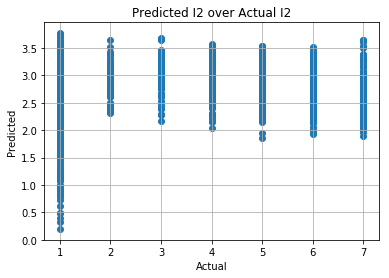

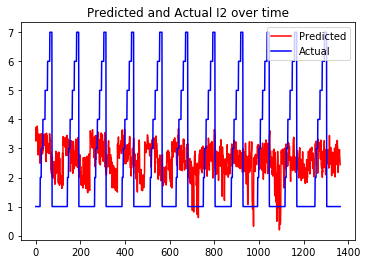

In [6]:
from sklearn import linear_model

# Create linear regression object
regr = linear_model.LinearRegression()

regr.fit(Xtrain1, ytrain1)
print(regr.coef_)
yTrainPredic = regr.predict(Xtrain1)

#plot the predict and true value
plt.scatter(ytrain1,yTrainPredic)
# plt.plot([0,7],[0,7],'r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted I2 over Actual I2')
plt.grid()

plt.figure()
plt.plot(yTrainPredic,'r',label = 'Predicted')
plt.plot(ytrain1,'b',label = 'Actual')
plt.title('Predicted and Actual I2 over time')
plt.legend()

# calculate the RSS for the prediction 
RSS_train = np.mean((yTrainPredic - ytrain1)**2)/(np.std(ytrain1)**2) 
print("Normalized RSS = {0:f}".format(RSS_train))

Normalized RSS = 0.920295


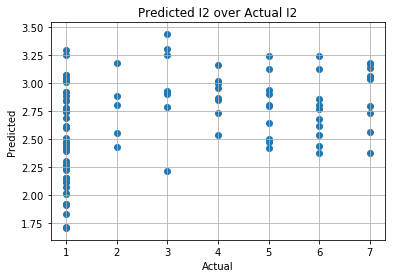

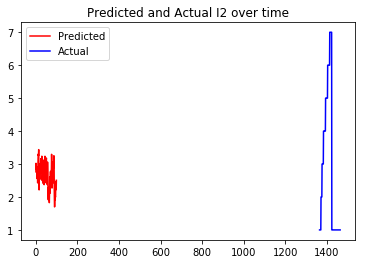

In [7]:
# fit the testing data
yTestPredict = regr.predict(Xtest1)
N = np.arange(numTest)

plt.scatter(ytest1,yTestPredict)
# plt.plot([0,7],[0,7],'r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted I2 over Actual I2')
plt.grid()

plt.figure()
plt.plot(yTestPredict,'r',label = 'Predicted')
plt.plot(ytest1,'b',label = 'Actual')
plt.title('Predicted and Actual I2 over time')
plt.legend()

RSS_test = np.mean((yTestPredict - ytest1)**2)/(np.std(ytest1)**2)
print("Normalized RSS = {0:f}".format(RSS_test))

## Part 2. LASSO

In [8]:
import  sklearn.model_selection
import sklearn.preprocessing

df2 = pd.read_csv('database1_csv.csv', na_values = '?', index_col = None)
#This data has missing values, fill with mean values from the non-missing values.
df3 = df2.fillna(df.mean())
df3.Date = df3.Date.apply(mapdateTotime)
X0 = df3[['Date','MaxTemp', 'MinTemp', 'MeanTemp', 'MaxGust', 'UVIndex', 'TotalPrecip']]
y0 = df3['Condition']
X2 = sklearn.preprocessing.scale(X0)
y2 = sklearn.preprocessing.scale(y0)

nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

model = linear_model.Lasso(warm_start=True)

nalpha = 100
alphas = np.logspace(-2,3,nalpha)

mse = np.zeros((nalpha,nfold))
for ifold, ind in enumerate(kf.split(X2)):

    Itr,Its = ind
    Xtr = X2[Itr,:]
    ytr = y2[Itr]
    Xts = X2[Its,:]
    yts = y2[Its]
    
    for ia, a in enumerate(alphas):
        model.alpha = a
        model.fit(Xtr,ytr)
        yts_pred = model.predict(Xts)
        mse[ia,ifold] = np.mean((yts_pred-yts)**2)
print(mse[1,:])


/Users/irenecai/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


[ 0.82608225  0.93520454  1.18998397  1.01150935  0.95785355  0.87282679
  0.83410976  0.92139323  0.93838067  0.90870267]


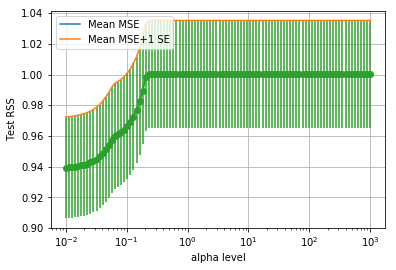

The selected model alpha is 0.010000


In [9]:
mse_mean_l = np.mean(mse,axis=1)
mse_std_l = np.std(mse,axis=1) / np.sqrt(nfold-1)

plt.semilogx(alphas, mse_mean_l)
plt.semilogx(alphas, mse_mean_l+mse_std_l)
plt.legend(['Mean MSE', 'Mean MSE+1 SE'],loc='upper left')
plt.errorbar(alphas, mse_mean_l, yerr=mse_std_l, fmt='o-')

#plt.ylim(0.95,1.05)
plt.xlabel('alpha level')
plt.ylabel('Test RSS')
plt.grid()
plt.show()

imin = np.argmin(mse_mean_l)
print("The selected model alpha is {0:f}".format(alphas[imin]))

The optimal model alpha is  0.11497569954
Mean test RSS per sample is  0.969183763766


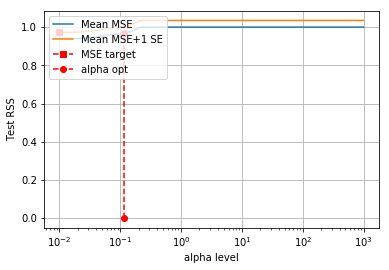

In [10]:
# Find the minimum RSS target
imin = np.argmin(mse_mean_l)
alpha_min = alphas[imin]
mse_tgt_l = mse_mean_l[imin] + mse_std_l[imin]

# Find the lowest model order below the target
I = np.where(mse_mean_l <= mse_tgt_l)[0]
iopt = I[-1]
dopt = alphas[iopt]
plt.semilogx(alphas, mse_mean_l)
plt.semilogx(alphas, mse_mean_l+mse_std_l)
plt.semilogx([alpha_min,alpha_min], [mse_tgt_l,mse_tgt_l], 'rs--')
plt.semilogx([dopt,dopt], [0.001,mse_mean_l[iopt]], 'ro--')
plt.legend(['Mean MSE', 'Mean MSE+1 SE', 'MSE target','alpha opt'],loc='upper left')

plt.xlabel('alpha level')
plt.ylabel('Test RSS')
plt.grid()

# Print results
print("The optimal model alpha is ", dopt)
print("Mean test RSS per sample is ", mse_mean_l[iopt])

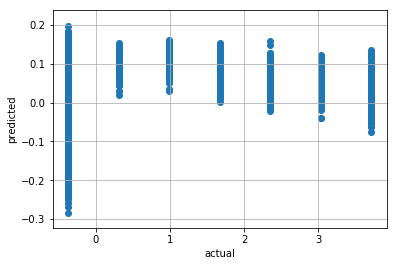

In [11]:
model.alpha = dopt
model.fit(X2,y2)
y_pred = model.predict(X2)
plt.scatter(y2,y_pred)
# plt.plot([0,7],[0,7],'r')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.grid()

## Part 3. Logistic Regression

In [12]:
import sklearn.model_selection
import sklearn.preprocessing

X3 = sklearn.preprocessing.scale(X0)
y3 = y0
logreg = linear_model.LogisticRegression()
logreg.fit(X3, y3)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [13]:
yhat1 = logreg.predict(X3)
acc1 = np.mean(yhat1 == y3)
print("Accuracy on training data = %f" % acc1)

Accuracy on training data = 0.857632


The optimal model C is  0.1
Accuracy  0.857626298874


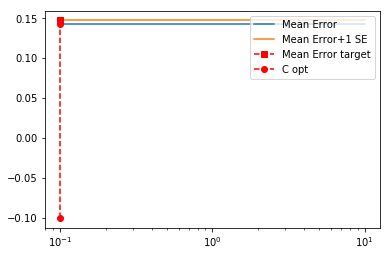

In [14]:
# try to optimize parameters of Logistic Regression
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold, shuffle = True)

model = linear_model.LogisticRegression(penalty = 'l1')

nC = 20
Cs = np.logspace(-1,1,nC)

mse = np.zeros((nC,nfold))
error = np.zeros((nC,nfold))

for ifold, ind in enumerate(kf.split(X3)):

    Itr,Its = ind
    Xtr2 = X3[Itr,:]
    ytr2 = y3[Itr]
    Xts2 = X3[Its,:]
    yts2 = y3[Its]
    
    for ia, a in enumerate(Cs):
        model.C = a
        model.fit(Xtr2,ytr2)
        yhat2 = model.predict(Xts2)
        mse[ia,ifold] = np.mean((yhat2-yts2)**2)
        error[ia,ifold] = np.mean(yhat2 != yts2)


error_mean = np.mean(error,axis = 1)
error_std = np.std(error,axis = 1)/np.sqrt(nfold-1)

imin = np.argmin(error_mean)

C_min = Cs[imin]
error_tgt = error_mean[imin] + error_std[imin]

I = np.where(error_mean <= error_tgt)[0]

Maxacc = 1-imin
iopt = I[0]
dopt = Cs[iopt]
plt.semilogx(Cs, error_mean)
plt.semilogx(Cs, error_mean+error_std)
plt.semilogx([C_min,dopt], [error_tgt,error_tgt], 'rs--')
plt.semilogx([dopt,dopt], [-0.1,error_mean[iopt]], 'ro--')
plt.legend(['Mean Error', 'Mean Error+1 SE', 'Mean Error target','C opt'],loc='upper right')

print("The optimal model C is ", dopt)
print("Accuracy ", 1 - error_mean[iopt])

## Part 4: Neural Network

Use Tensorflow for creating neural network and training it on database1. It takes the date, MaxTemp, MinTemp, MeanTemp, MaxGust, UVIndex and TotalPrecip as input to compute a prediction for the leaf color condition index.

In [15]:
col1 = df3[['Date','MaxTemp','MinTemp','MeanTemp', 'MaxGust', 'UVIndex','TotalPrecip']]
col2 = df3['Condition']

#Convert to Numpy array
X1 = col1.as_matrix()
Y1 = col2.as_matrix()

#Min-max Normalization 
X1_norm = (X1-np.amin(X1,0))/(np.amax(X1,0)-np.amin(X1,0))
Y1_norm = Y1  #No normalization in output

#Reshape
Xfeatures = 6 #Number of input features  
Yfeatures = 1 #Number of input features 
samples = Y1.shape[0] # Number of samples   

X1_reshape = np.resize(X1_norm,(samples,Xfeatures))
Y1_reshape = np.resize(Y1_norm,(samples,Yfeatures))

In [16]:
#Training data
vsize = 1000
tsize = samples - vsize

X1train = X1_reshape[0:tsize,:]
Y1train = Y1_reshape[0:tsize,:]

#Validation data
X1v = X1_reshape[tsize:tsize+vsize,:]
Y1v = Y1_reshape[tsize:tsize+vsize,:]

In [17]:
#Input
X = tf.placeholder(tf.float32,shape=(None,Xfeatures))

#Output
Y = tf.placeholder(tf.float32)

In [18]:
#Neurons
L1 = 5
L2 = 5
L3 = 5
L4 = 5
L5 = 5

#Layer1 weights
W1 = tf.Variable(tf.random_uniform([Xfeatures,L1]))
b1 = tf.Variable(tf.constant(0.1,shape=[L1]))

#Layer2 weights
W2 = tf.Variable(tf.random_uniform([L1,L2]))
b2 = tf.Variable(tf.constant(0.1,shape=[L2]))

#Layer3 weights
W3 = tf.Variable(tf.random_uniform([L2,L3]))
b3 = tf.Variable(tf.constant(0.1,shape=[L3]))

#Layer4 weights
W4 = tf.Variable(tf.random_uniform([L3,L4]))
b4 = tf.Variable(tf.constant(0.1,shape=[L4]))

#Layer5 weights
W5 = tf.Variable(tf.random_uniform([L4,L5]))
b5 = tf.Variable(tf.constant(0.1,shape=[L5]))

#Output layer weights
W_O = tf.Variable(tf.random_uniform([L5,Yfeatures]))
b_O = tf.Variable(tf.constant(0.1,shape=[Yfeatures]))

In [19]:
#Layer 1
matmul_1=tf.matmul(X, W1) + b1
h1 = tf.nn.relu(matmul_1)   #ReLU activation

#Layer 2
matmul_2=tf.matmul(h1, W2) + b2
h2 = tf.nn.relu(matmul_2)   #ReLU activation

#Layer 3
matmul_3=tf.matmul(h2, W3) + b3
h3 = tf.nn.relu(matmul_3)   #ReLU activation

#Layer 4
matmul_4=tf.matmul(h3, W4) + b4
h4 = tf.nn.relu(matmul_4)   #ReLU activation

#Layer 5
matmul_5=tf.matmul(h4, W5) + b5
h5 = tf.nn.relu(matmul_5)   #ReLU activation

#Output layer
matmul_6=tf.matmul(h5, W_O) + b_O
#output_layer = matmul_6  #linear activation
output_layer = tf.transpose(tf.matmul(h5, W_O) + b_O)

In [20]:
lr = 0.001  # learning rate
epoch = 1000
batch_size = 100

#Loss function
mean_square =  tf.reduce_mean(tf.square(Y-output_layer))
opt = tf.train.AdamOptimizer(lr).minimize(mean_square)

#Operation to save variables
saver = tf.train.Saver()

In [21]:
#Initialization and session
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(epoch):
        # Shuffle training data
        shuffle_indices = np.random.permutation(np.arange(len(Y1train)))
        X_train = X1train[shuffle_indices]
        y_train = Y1train[shuffle_indices]
        # Minibatch training
        for i in range(0, len(y_train) // batch_size):
            start = i * batch_size
            batch_x = X_train[start:start + batch_size]
            batch_y = y_train[start:start + batch_size]
            
            # Run optimizer with batch
            sess.run([opt],feed_dict={X:batch_x,Y:batch_y})
            
    print("Final training loss:",sess.run([mean_square],feed_dict={X:batch_x,Y:batch_y}))
    print("Final validation loss:",sess.run([mean_square],feed_dict={X:X1v,Y:Y1v}))


Final training loss: [1.523937]
Final validation loss: [2.3304307]


## Part 5: Conclusion

1.Since we are lacking of the data (we only have 4382 samples in total, from 2005 to 2016), result is not the optimal prediction. 

2.In this prediction, Linear regression and LASSO have bad performance since they are linear. We tried the Logistic Regression and Neural Network, which predict well. And since the Linear model is influenced greatly by the data, the large amount of same data will do bad to the prediction. And the leaf condition from December to July of next year are all 1(which means no need to visit), we remove them from the original database1_csv.csv file and make a new database for linear prediction in database2_csv.csv. By using this data, the result is much better, but still not strong for prediction result.

3.Logistic Regression performance better than linear methods, the accurancy is around 0.86, this may due to the small amount of data. But this still needs to be validated.

4.Since we need huge data to train the best model in Neural network, the prediection in part 4 is not perfect. The training and testing loss is around 2, which can be decreased greatly if we use 20000 samples or more or even more and more.